# Exercise: Transcription

1. Try experimenting with an alternative (non-linear) activation function to the `sigmoid` function used in the baseline model. A list of activation functions is available [here](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions)
1. Try changing the number of channels in the first convolutional layer (`self.conv1`) from 16 to 32. What else do you need to change to ensure the model still work? How does this affect the number of parameters of the model?
1. Experiment with, e.g., the numbers of layers in your model (**note**: this may necessitate appropriately asjusting the subsequent layers), the choice of optimizer and learning rate, or the number of epochs. How high performance can you achieve on the test split?

To get you started, run the code in the [A baseline model](#a-baseline-model)-section of this notebook.

## Setup

#### Dependencies

In [1]:
import torch

from torch import Tensor, nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from matplotlib import pyplot as plt

#### Download data

In [2]:
image_transforms = transforms.ToTensor() # convert to Tensors our models can work with

In [3]:
from dirs import DATA_DIR

train_dataset = datasets.MNIST(root=DATA_DIR, train=True, download=True, transform=image_transforms)
test_dataset = datasets.MNIST(root=DATA_DIR, train=False, download=True, transform=image_transforms)

In [4]:
train_data_loader = DataLoader(train_dataset, batch_size=32)
test_data_loader = DataLoader(test_dataset, batch_size=32)

*Let's take a look*

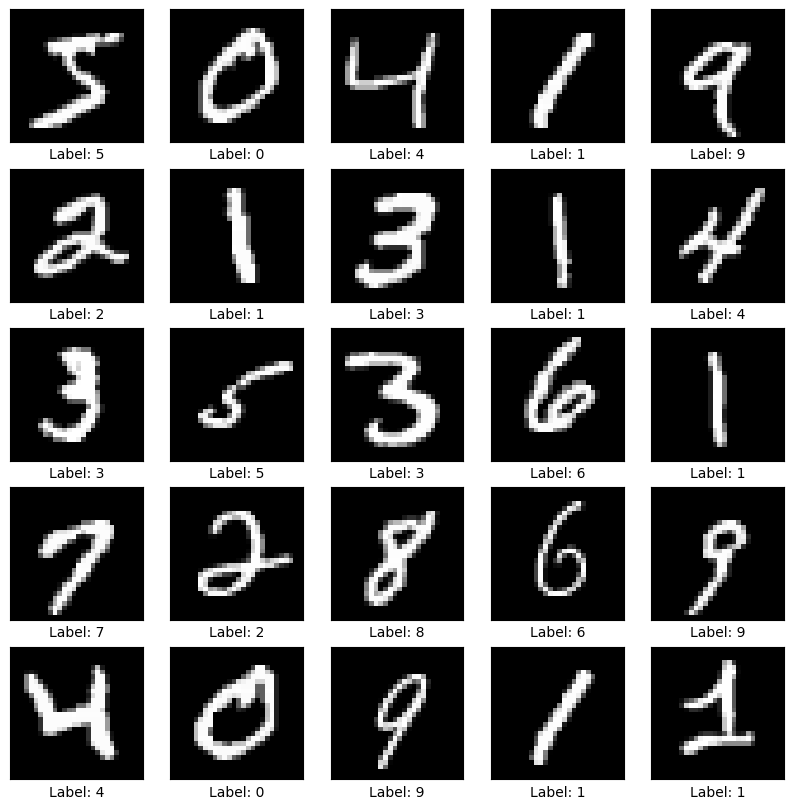

In [5]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_dataset[i][0][0], cmap='gray')
    plt.xlabel(f'Label: {train_dataset[i][1]}')
plt.show()

#### A baseline model

In [6]:
class HandwrittenDigitsRecognizer(nn.Module):
    '''
    Baseline handwritten digits neural network. Note that the
    dimensions of the intermediate states; see the comments
    in the `forward` module, which shows all dimensions during
    the forward pass. Note that the initial dimensions of our
    images is (1, 28, 28), which means a greyscale (hence the 1)
    images 28 pixels high and wide.

    The changes in dimensions occur for the following reasons:
    1)  With a 3x3 kernel, we lose 1 pixels on the edges, which
        changes the heigh and width from 28x28 to 26x26. We also
        change the number of channels from 1 to 16.
    2)  Using pooling with a kernel size of 2x2 and strides 2x2,
        we change each 4x4 block to a 1x1 block, which changes the
        heigh and width from 26x26 to 13x13 (one fourth)
    3)  With a 3x3 kernel, we lose 1 pixels on the edges, which
        changes the heigh and width from 13x13 to 11x11. We also
        change the number of channels from 16 to 32.
    4)  Using pooling with a kernel size of 2x2 and strides 2x2,
        we change each 4x4 block to a 1x1 block, which changes the
        heigh and width from 11x11 to 5x5 (one fourth, where we also
        lose some pixels as 11 isn't divisible by 2).
    5)  Flattening refers to collapsing our representation from three
        to dimension, and since 5*5*32 = 800, we end up with 800 elements
        in the resulting vector.
    6)  Finally, we want to reduce the dimensions to 10, as we have ten
        distinct classes (the numbers 0-9).

    If you want to change, e.g., the number of channels in one of the
    convolutional layers, you need to also consider how this affects
    the subsequent layer.

    '''

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, 1) # from 1 to 16 channels, 3x3 kernels, stride = 1
        self.conv2 = nn.Conv2d(16, 32, 3, 1) # from 16 to 32 channels, 3x3 kernels, stride = 1
        self.classifier = nn.Linear(800, 10) # from 800 to 10-way classification (0-9)

    def forward(self, image: Tensor) -> Tensor:
        out = self.conv1(image) # (1, 28, 28) -> (16, 26, 26)
        out = torch.sigmoid(out)
        out = nn.functional.max_pool2d(out, 2) # (16, 26, 26) -> (16, 13, 13)

        out = self.conv2(out) # (16, 13, 13) -> (32, 11, 11)
        out = torch.sigmoid(out)
        out = nn.functional.max_pool2d(out, 2) # (32, 11, 11) -> (32, 5, 5)

        out = torch.flatten(out, 1) # (32, 5, 5) -> (800,)
        out = self.classifier(out) # (800,) -> (10,)

        return out

*We can reuse our training loop from earlier...*

In [7]:
def train_epoch(model, optimizer, data_loader, loss_fn):
    model.train()

    for image, label in data_loader:
        optimizer.zero_grad()
        
        out = model(image) # make predictions
        loss = loss_fn(out, label) # calculate loss
        loss.backward() # calculate derivatives

        optimizer.step() # update network parameters

*... as well as our evaluation loop*

In [8]:
@torch.no_grad
def evaluate(model, data_loader):
    model.eval()

    total_correct = 0 # keep count of correct predictions
    total_count = 0 # keep count of total number of predictions

    for image, label in data_loader:
        out = model(image).argmax(1)

        total_correct += (out == label).sum().item()
        total_count += label.size(0)

    return total_correct / total_count # calculate accuracy

In [9]:
model_baseline = HandwrittenDigitsRecognizer()
optimizer_baseline = torch.optim.SGD(model_baseline.parameters(), lr=0.01)

loss_fn = torch.nn.CrossEntropyLoss()

In [10]:
print(f'Number of parameters: {sum(p.numel() for p in model_baseline.parameters()):,}')

Number of parameters: 12,810


In [11]:
for epoch in range(1, 11):
    train_epoch(model_baseline, optimizer_baseline, train_data_loader, loss_fn)
    acc = evaluate(model_baseline, test_data_loader)

    print(f'Trained for {epoch} epochs. Validation accuracy: {100 * acc}%')

Trained for 1 epochs. Validation accuracy: 9.6%
Trained for 2 epochs. Validation accuracy: 70.6%
Trained for 3 epochs. Validation accuracy: 81.56%
Trained for 4 epochs. Validation accuracy: 86.2%
Trained for 5 epochs. Validation accuracy: 88.28%
Trained for 6 epochs. Validation accuracy: 89.59%
Trained for 7 epochs. Validation accuracy: 90.51%
Trained for 8 epochs. Validation accuracy: 91.24%
Trained for 9 epochs. Validation accuracy: 91.8%
Trained for 10 epochs. Validation accuracy: 92.44%


Visualizing predictions

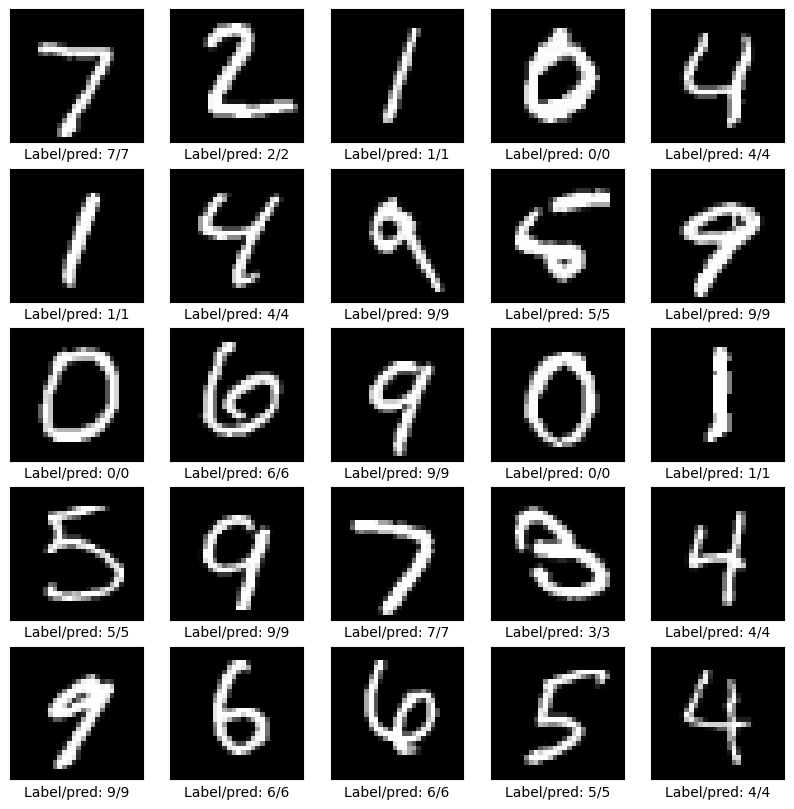

In [12]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image, label = test_dataset[i]
    pred = model_baseline(image.unsqueeze(0)).argmax()
    
    plt.imshow(image[0], cmap='gray')    
    plt.xlabel(f'Label/pred: {label}/{pred}')

plt.show()

# Exercise 1

In [13]:
class HandwrittenDigitsRecognizerReLU(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, 1) # from 1 to 3 channels, 3x3 kernels, stride = 1
        self.conv2 = nn.Conv2d(16, 32, 3, 1) # from 16 to 32 channels, 3x3 kernels, stride = 1
        self.classifier = nn.Linear(800, 10) # from 800 to 10-way classification (0-9)

    def forward(self, image: Tensor) -> Tensor:
        out = self.conv1(image) # (1, 28, 28) -> (16, 26, 26)
        out = torch.relu(out)
        out = nn.functional.max_pool2d(out, 2) # (16, 26, 26) -> (16, 13, 13)

        out = self.conv2(out) # (16, 13, 13) -> (32, 11, 11)
        out = torch.relu(out)
        out = nn.functional.max_pool2d(out, 2) # (32, 11, 11) -> (32, 5, 5)

        out = torch.flatten(out, 1) # (32, 5, 5) -> (800,)
        out = self.classifier(out) # (800,) -> (10,)

        return out

In [14]:
model_relu = HandwrittenDigitsRecognizerReLU()
optimizer_relu = torch.optim.SGD(model_relu.parameters(), lr=0.01)

In [15]:
for epoch in range(1, 11):
    train_epoch(model_relu, optimizer_relu, train_data_loader, loss_fn)
    acc = evaluate(model_relu, test_data_loader)

    print(f'Trained for {epoch} epochs. Validation accuracy: {100 * acc}%')

Trained for 1 epochs. Validation accuracy: 92.69%
Trained for 2 epochs. Validation accuracy: 95.69%
Trained for 3 epochs. Validation accuracy: 96.57%
Trained for 4 epochs. Validation accuracy: 97.08%
Trained for 5 epochs. Validation accuracy: 97.35000000000001%
Trained for 6 epochs. Validation accuracy: 97.55%
Trained for 7 epochs. Validation accuracy: 97.74000000000001%
Trained for 8 epochs. Validation accuracy: 97.8%
Trained for 9 epochs. Validation accuracy: 97.92999999999999%
Trained for 10 epochs. Validation accuracy: 97.95%


# Exercise 2

In [16]:
class HandwrittenDigitsRecognizerReLULarge(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, 1) # from 1 to 32 channels, 3x3 kernels, stride = 1
        self.conv2 = nn.Conv2d(32, 32, 3, 1) # from 32 to 32 channels, 3x3 kernels, stride = 1
        self.classifier = nn.Linear(800, 10) # from 800 to 10-way classification (0-9)

    def forward(self, image: Tensor) -> Tensor:
        out = self.conv1(image) # (1, 28, 28) -> (16, 26, 26)
        out = torch.relu(out)
        out = nn.functional.max_pool2d(out, 2) # (16, 26, 26) -> (16, 13, 13)

        out = self.conv2(out) # (16, 13, 13) -> (32, 11, 11)
        out = torch.relu(out)
        out = nn.functional.max_pool2d(out, 2) # (32, 11, 11) -> (32, 5, 5)

        out = torch.flatten(out, 1) # (32, 5, 5) -> (800,)
        out = self.classifier(out) # (800,) -> (10,)

        return out

In [17]:
model_large = HandwrittenDigitsRecognizerReLULarge()
optimizer_large = torch.optim.SGD(model_large.parameters(), lr=0.01)

In [18]:
print(f'Number of parameters: {sum(p.numel() for p in model_large.parameters()):,}')

Number of parameters: 17,578


In [19]:
for epoch in range(1, 11):
    train_epoch(model_large, optimizer_large, train_data_loader, loss_fn)
    acc = evaluate(model_large, test_data_loader)

    print(f'Trained for {epoch} epochs. Validation accuracy: {100 * acc}%')

Trained for 1 epochs. Validation accuracy: 92.94%
Trained for 2 epochs. Validation accuracy: 95.67%
Trained for 3 epochs. Validation accuracy: 96.55%
Trained for 4 epochs. Validation accuracy: 97.02%
Trained for 5 epochs. Validation accuracy: 97.28999999999999%
Trained for 6 epochs. Validation accuracy: 97.52%
Trained for 7 epochs. Validation accuracy: 97.61999999999999%
Trained for 8 epochs. Validation accuracy: 97.78999999999999%
Trained for 9 epochs. Validation accuracy: 97.89%
Trained for 10 epochs. Validation accuracy: 97.98%


# Exercise 3

In [20]:
class HandwrittenDigitsRecognizerReLUDeeper(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, 1) # from 1 to 16 channels, 3x3 kernels, stride = 1
        self.conv2 = nn.Conv2d(16, 32, 3, 1) # from 16 to 32 channels, 3x3 kernels, stride = 1
        self.conv3 = nn.Conv2d(32, 64, 3, 1) # from 32 to 64 channels, 3x3 kernels, stride = 1
        self.classifier = nn.Linear(1600, 10) # from 800 to 10-way classification (0-9)

    def forward(self, image: Tensor) -> Tensor:
        out = self.conv1(image) # (1, 28, 28) -> (16, 26, 26)
        out = torch.relu(out)
        out = self.conv2(out) # (1, 26, 26) -> (16, 24, 24)
        out = torch.relu(out)
        out = nn.functional.max_pool2d(out, 2) # (16, 24, 24) -> (16, 12, 12)

        out = self.conv3(out) # (16, 12, 12) -> (32, 10, 10)
        out = torch.relu(out)
        out = nn.functional.max_pool2d(out, 2) # (32, 10, 10) -> (32, 5, 5)

        out = torch.flatten(out, 1) # (64, 5, 5) -> (1600,)
        out = self.classifier(out) # (1600,) -> (10,)

        return out

In [21]:
model_deep = HandwrittenDigitsRecognizerReLUDeeper()
optimizer_deep = torch.optim.SGD(model_deep.parameters(), lr=0.01)

In [22]:
print(f'Number of parameters: {sum(p.numel() for p in model_deep.parameters()):,}')

Number of parameters: 39,306


In [23]:
for epoch in range(1, 11):
    train_epoch(model_deep, optimizer_deep, train_data_loader, loss_fn)
    acc = evaluate(model_deep, test_data_loader)

    print(f'Trained for {epoch} epochs. Validation accuracy: {100 * acc}%')

Trained for 1 epochs. Validation accuracy: 95.32000000000001%
Trained for 2 epochs. Validation accuracy: 97.06%
Trained for 3 epochs. Validation accuracy: 97.6%
Trained for 4 epochs. Validation accuracy: 97.94%
Trained for 5 epochs. Validation accuracy: 98.2%
Trained for 6 epochs. Validation accuracy: 98.39%
Trained for 7 epochs. Validation accuracy: 98.47%
Trained for 8 epochs. Validation accuracy: 98.52%
Trained for 9 epochs. Validation accuracy: 98.56%
Trained for 10 epochs. Validation accuracy: 98.55000000000001%
